# Found which scaffolds we need to delete from input set and create new inactive set

# Library import

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.DataManip.Metric import GetTanimotoSimMat
from rdkit.Chem import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.ML.Cluster.Butina import EuclideanDist
from rdkit.ML.KNN.DistFunctions import TanimotoDist


#descripts
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

from rdkit.Chem.Lipinski import NumAromaticHeterocycles
from rdkit.Chem.Lipinski import NumAliphaticRings
from rdkit.Chem.Lipinski import NumAromaticHeterocycles
from rdkit.Chem.Lipinski import NumAromaticRings

from rdkit.Chem.SaltRemover import SaltRemover

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import matthews_corrcoef
import statistics

# plots
from matplotlib import pyplot
import seaborn

import itertools
from itertools import combinations

import numpy as np

from sklearn.metrics import jaccard_score

import os
import matplotlib.pyplot as plt

## Loading data

In [6]:
#Function for solved the problem from SF5- convert to CF3
rxn = AllChem.ReactionFromSmarts\
('[*:0][S:1]([F:2])([F:3])([F:4])([F:5])[F:6]>>[*:0]-[C](-[F])(-[F])-[F].[*:1]([*:2])([*:3])([*:4])([*:5])[*:6]')
def MakeScaffoldGeneric_fixed(mol):
    for i in range(len(mol.GetSubstructMatches(Chem.MolFromSmiles("S(F)(F)(F)(F)F")))):
        products = rxn.RunReactants((mol,)) # tuple
        if len(products)>0:
            mol = products[0][0]
    return MakeScaffoldGeneric(mol)

In [7]:
def loading_processing_data(name_file,name):

    dff = pd.read_csv(f"{name_file}/{name}",header=None)
    dff.columns =['molregno', 'stand_type', 
                                    'pchembl_value', 'stand_value',
                                    'canonical_smiles', 'stand_inchi',
                                   'chembl_id', 'tid','pref_name']
            

    dff['scaffolds_csk'] = [1 for x in range(len(dff))]
    delete_element = 0
    for x in range(len(dff)):
        #Remove salt
        remover = SaltRemover()
        res = remover.StripMol(Chem.MolFromSmiles(dff['canonical_smiles'][x]))
        dff['canonical_smiles'][x] = Chem.MolToSmiles(res)
        #If not contains the ring remove too
        if NumAromaticRings(Chem.MolFromSmiles(dff['canonical_smiles'][x])) == 0 and\
            NumAliphaticRings(Chem.MolFromSmiles(dff['canonical_smiles'][x])) == 0:
            print("Not contain ring")
            print(dff['canonical_smiles'][x])
            display(Chem.MolFromSmiles(dff['canonical_smiles'][x]))
            dff = dff.drop([x])
            delete_element = 1
        if delete_element != 1:
            try:
                dff['scaffolds_csk'].loc[x] = MurckoScaffoldSmiles(\
                                         Chem.MolToSmiles(MakeScaffoldGeneric\
                                       (Chem.MolFromSmiles(dff['canonical_smiles'][x]))))
            except:
                print("Faild to create scaffold_csk")
                print("Index",x)
                print(dff['canonical_smiles'][x])
                display(Chem.MolFromSmiles(dff['canonical_smiles'][x]))
                try:
                    mol = MakeScaffoldGeneric_fixed(Chem.MolFromSmiles(dff['canonical_smiles'][x]))
                    display(mol)
                    dff['scaffolds_csk'].loc[x] = MurckoScaffoldSmiles(Chem.MolToSmiles(mol))
                    display(Chem.MolFromSmiles(MurckoScaffoldSmiles(Chem.MolToSmiles(mol))))
                except:
                    dff = dff.drop([x])
        delete_element = 0

    #calculate stand_inchi_key and morgan finderprints
    dff['stand_inchi'] = [Chem.inchi.MolToInchiKey(Chem.MolFromSmiles(y)) for y in dff['canonical_smiles']]
    dff['mfp'] = [(AllChem.GetMorganFingerprintAsBitVect\
                (Chem.MolFromSmiles(i),3, nBits=2048)) for i in dff['scaffolds_csk']]
      
    dff.reset_index(level=0, inplace=True)
    dff = dff.drop(columns = ['index'])
    return dff

In [28]:
def duplicate_compounds(df):
    '''Function for find and work with duplicates'''

    duplicateRows = df[df['stand_inchi'].duplicated()] #all duplicated rows
    arr_duplicates = []
    for x in duplicateRows.index:
        if x not in arr_duplicates:
            inchikey = duplicateRows.stand_inchi[x]  #inchikey of duplicates
            duplicated_df = df[df.stand_inchi==inchikey] #find other duplicates row
            duplicated_df_index = duplicated_df.index #all index in duplicates dataframe
            #dictioanry with index:pchemble_value and index_class(active_inactive)
            duplicates_dict_pchembl = {list(duplicated_df.index)[i] : list(duplicated_df.pchembl_value)[i] for i in range(len(duplicated_df))}
            duplicates_dict_class = {list(duplicated_df.index)[i] : 'active' if list(duplicated_df.stand_value)[i] <= 100 else 'inactive' for i in range(len(duplicated_df))}

            for t in duplicated_df_index:
                arr_duplicates.append(t)
            #If we have one same class active or inactive calculate onlly mean value
            if len(set(list(duplicates_dict_class.values()))) == 1:
                new_value = duplicated_df.pchembl_value.mean() #new value, select all value in duplicates set and then calculate mean value                
                leave_id = duplicated_df_index[0] #index wich we leave in dataframe and others duplicqates we deleted

                df.loc[leave_id, 'pchembl_value'] = new_value #add new value

                duplicated_df_index = duplicated_df_index.drop(leave_id) # index wich we need to delete
                for z in duplicated_df_index:
                    df = df.drop([z])  #delete duplicate
            #If we have more then 4 duplicates -> deleted outliers and then check if the remainning values have the same class,
            #if yes we calculate mean value if not only delete yhis rows
            elif len(list(duplicates_dict_class.values())) > 4:
                q1 = np.quantile(list(duplicates_dict_pchembl.values()),0.25)
                q3 = np.quantile(list(duplicates_dict_pchembl.values()),0.75)
                iqr = q3 - q1
                deleted_index = []
                for index,pchembl in duplicates_dict_pchembl.items():
                    if pchembl > (q3 + 1.5*iqr) or pchembl < (q1 - 1.5*iqr) :
                        deleted_index.append(index) #If we found outlier deleted them from alll datastructures

                for index in deleted_index:
                    duplicates_dict_pchembl.pop(index)
                    duplicates_dict_class.pop(index)
                    df = df.drop([index])
                    duplicated_df_index = duplicated_df_index.drop(index)
                    
                if len(set(list(duplicates_dict_class.values()))) == 1:
                    new_value = sum(duplicates_dict_pchembl.values())/len(duplicates_dict_pchembl) #new value, select all value in duplicates set and then calculate mean value                
                    leave_id = duplicated_df_index[0] #index wich we leave in dataframe and others duplicqates we deleted
                    df.loc[leave_id, 'pchembl_value'] = new_value
                    duplicated_df_index = duplicated_df_index.drop(leave_id) # inbdex wich we need to delete
                    for z in duplicated_df_index:
                        df = df.drop([z])  #delete duplicate
                #delete if it not the same class
                else:
                    for z in duplicated_df_index:
                        df = df.drop([z])  #delete duplicate
            #if we have less the 4 calculating, only delete this rows
            else:
                for z in duplicated_df_index:
                    df = df.drop([z])  #delete duplicate

    '''Only check if the numbers is the same'''
    print("Number of unique smiles value:", len(df.canonical_smiles.unique()))
    array_inchi_key = [Chem.inchi.MolToInchiKey(Chem.MolFromSmiles(x)) for x in df.canonical_smiles]
    print("Number of unique inchikey ", len(set(array_inchi_key)))
    print("Number of datasets", len(df))
    if len(df.canonical_smiles.unique()) == len(set(array_inchi_key)) == len(df):
        print("Everything is okay")
    else:
        print("Something wrong with your duplicates")
    df.reset_index(level=0, inplace=True)
    df = df.drop(columns = ['index'])

    return df

In [61]:
#data with all compounds for Glucocorticoid_receptor
#glucocor = loading_processing_data('data/input_recall_sets_new/Glucocorticoid_receptor','Glucocorticoi_receptro_all_data.csv')
glucocor = loading_processing_data('data/input_recall_sets_new/Glucocorticoid_receptor','Glucocorticoi_receptro_all_data.csv')
#glucocor.to_csv('data/input_recall_sets/Glucocorticoid_receptor/new_sets/Glucocorticoid_receptor.csv', index_label = False)
glucocor

/tmp/ipykernel_10264/3448070860.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['canonical_smiles'][x] = Chem.MolToSmiles(res)
/tmp/ipykernel_10264/3448070860.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['scaffolds_csk'].loc[x] = MurckoScaffoldSmiles(\


,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,scaffolds_csk,mfp
0,226650,IC50,6.13,737.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1)Oc1ccc...,ZEZOALAOUQCQQW-HAHDFKILSA-N,CHEMBL134421,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,49963,IC50,6.34,458.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1cccc(F)c1)Oc1...,OVIZCQBEPZRBDB-UCQKPKSFSA-N,CHEMBL32812,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,71774,IC50,6.82,150.0,C/C=C/CC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(...,BSJYFMFPTGYKFE-VOTSOKGWSA-N,CHEMBL47742,25,Glucocorticoid receptor,C1CCC2C(C1)CCC1C3CCCCC3CCC21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,226190,IC50,6.43,371.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1cc(F)ccc1F)Oc...,ZVALABNDJZPNNC-QRVIBDJDSA-N,CHEMBL137103,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,227145,IC50,5.78,1650.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccc(F)c(F)c1)...,XGBWGDGYTTWUIM-QRVIBDJDSA-N,CHEMBL342426,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
2622,2514528,IC50,8.15,7.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@H]3CCCN(C(=O)[C@...,IHSJODAUGPFFCM-FJYDYCOSSA-N,CHEMBL4777937,25,Glucocorticoid receptor,C1CCC(CCC2CCC(CCC3CCCC(CC4CCCC4)C3)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2623,2502352,IC50,8.05,9.0,Cc1ccc([C@@H](Oc2ccc(C(=O)NC3CCCCC3)nc2)[C@H](...,LZNNVIVDLGFSQD-KKSFZXQISA-N,CHEMBL4755015,25,Glucocorticoid receptor,C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2624,2515140,IC50,7.58,26.0,Cc1ccc([C@@H](Oc2ccc(C(=O)Nc3ccccc3)nc2)[C@H](...,KJELVKWMZHVGSD-KKSFZXQISA-N,CHEMBL4778549,25,Glucocorticoid receptor,C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2625,2505900,IC50,8.70,2.0,Cc1ccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@...,BUPAQOQEQDIOPK-HJPURHCSSA-N,CHEMBL4758563,25,Glucocorticoid receptor,C1CCC(CCC2CCC3C(CCC3C3CCCCC3)C2)CC1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [62]:
len(set(list(glucocor.stand_inchi)))

1638

In [63]:
len(set(list(glucocor.canonical_smiles)))

1638

In [66]:
glucocor_without_duplicates = duplicate_compounds(glucocor)
#glucocor_without_duplicates.to_csv('data/input_recall_sets_new/Glucocorticoid_receptor/Glucocorticoid_receptor_without_duplicates.csv', index_label = False)
glucocor_without_duplicates

Number of unique smiles value: 1445
Number of unique inchikey  1445
Number of datasets 1445
Everything is okay


,molregno,stand_type,pchembl_value,stand_value,canonical_smiles,stand_inchi,chembl_id,tid,pref_name,scaffolds_csk,mfp
0,226650,IC50,6.13,737.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1)Oc1ccc...,ZEZOALAOUQCQQW-HAHDFKILSA-N,CHEMBL134421,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,49963,IC50,6.34,458.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1cccc(F)c1)Oc1...,OVIZCQBEPZRBDB-UCQKPKSFSA-N,CHEMBL32812,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,226190,IC50,6.43,371.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1cc(F)ccc1F)Oc...,ZVALABNDJZPNNC-QRVIBDJDSA-N,CHEMBL137103,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,227145,IC50,5.78,1650.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccc(F)c(F)c1)...,XGBWGDGYTTWUIM-QRVIBDJDSA-N,CHEMBL342426,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,100045,IC50,5.98,1050.0,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1C)Oc1cc...,YXKBVHXOKVRRKO-IWIPYMOSSA-N,CHEMBL302362,25,Glucocorticoid receptor,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
1440,2517273,IC50,7.05,90.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@@H]3CCCN(C(=O)[C...,IHSJODAUGPFFCM-BWWCKNBVSA-N,CHEMBL4780682,25,Glucocorticoid receptor,C1CCC(CCC2CCC(CCC3CCCC(CC4CCCC4)C3)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1441,2514528,IC50,8.15,7.0,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@H]3CCCN(C(=O)[C@...,IHSJODAUGPFFCM-FJYDYCOSSA-N,CHEMBL4777937,25,Glucocorticoid receptor,C1CCC(CCC2CCC(CCC3CCCC(CC4CCCC4)C3)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1442,2502352,IC50,8.05,9.0,Cc1ccc([C@@H](Oc2ccc(C(=O)NC3CCCCC3)nc2)[C@H](...,LZNNVIVDLGFSQD-KKSFZXQISA-N,CHEMBL4755015,25,Glucocorticoid receptor,C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1443,2515140,IC50,7.58,26.0,Cc1ccc([C@@H](Oc2ccc(C(=O)Nc3ccccc3)nc2)[C@H](...,KJELVKWMZHVGSD-KKSFZXQISA-N,CHEMBL4778549,25,Glucocorticoid receptor,C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Load all sets, new active, inactive and old active and inactive. And find the scaffolds what not in new active set

In [67]:
nuclear_nonactive = glucocor_without_duplicates[glucocor_without_duplicates.pchembl_value<7]
nuclear_nonactive = nuclear_nonactive.reset_index(drop=True)
nuclear_nonactive = nuclear_nonactive[['chembl_id','pchembl_value','canonical_smiles','scaffolds_csk']]
#nuclear_nonactive.to_csv('data/input_recall_sets_new/Glucocorticoid_receptor/Glucocorticoid_receptor_non_active_compounds.csv', index_label = False)
nuclear_nonactive['source'] = 'inactive'
nuclear_nonactive

,chembl_id,pchembl_value,canonical_smiles,scaffolds_csk,source
0,CHEMBL134421,6.13,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1)Oc1ccc...,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,inactive
1,CHEMBL32812,6.34,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1cccc(F)c1)Oc1...,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,inactive
2,CHEMBL137103,6.43,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1cc(F)ccc1F)Oc...,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,inactive
3,CHEMBL342426,5.78,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccc(F)c(F)c1)...,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,inactive
4,CHEMBL302362,5.98,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1C)Oc1cc...,C1CCC(CC2CC3CCCCC3C3CCC4CCCCC4C23)CC1,inactive
...,...,...,...,...,...
478,CHEMBL4742925,5.50,COC(=O)C(c1ccc(F)cc1Cl)n1ccc2c(NS(C)(=O)=O)cccc21,C1CCC(CC2CCC3CCCCC32)CC1,inactive
479,CHEMBL4744881,5.30,Cc1ccc([C@@H](Oc2ccc(C(=O)Nc3ccccc3)cc2)[C@H](...,C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1,inactive
480,CHEMBL4865865,4.70,CN1CCC(Oc2ccc(N3C(=S)N(c4cnc(C#N)c(C(F)(F)F)c4...,C1CCC(CC2CCC(C3CC(C4CCCCC4)CC34CCC4)CC2)CC1,inactive
481,CHEMBL1082407,4.54,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,C1CCC(C2CCC(C3CCCCC3)C2)CC1,inactive


In [68]:
nuclear_active = glucocor_without_duplicates[glucocor_without_duplicates.pchembl_value>=7]
nuclear_active = nuclear_active.reset_index(drop=True)
nuclear_active = nuclear_active[['chembl_id','pchembl_value','canonical_smiles','scaffolds_csk']]
#nuclear_active.to_csv('data/input_recall_sets_new/Glucocorticoid_receptor/Glucocorticoid_receptor_active_compounds.csv', index_label = False)
nuclear_active['source'] = [['active'] for x in range(len(nuclear_active))]
nuclear_active

,chembl_id,pchembl_value,canonical_smiles,scaffolds_csk,source
0,CHEMBL46325,7.560,COc1cccc2c1-c1ccc3c(c1[C@H]([C@H]1C=C(C)CCC1)O...,C1CCC(C2CC3CCCCC3C3CCC4CCCCC4C23)CC1,[active]
1,CHEMBL47463,7.920,COc1cccc2c1-c1ccc3c(c1C(C1C=CCC1)O2)C(C)=CC(C)...,C1CCC2C(C1)CC(C1CCCC1)C1C3CCCCC3CCC21,[active]
2,CHEMBL50118,7.410,COc1cccc2c1-c1ccc3c(c1C(CC=C(F)F)O2)C(C)=CC(C)...,C1CCC2C(C1)CCC1C3CCCCC3CCC21,[active]
3,CHEMBL48588,7.985,COc1cccc2c1-c1ccc3c(c1C(C1C=C(C)CCC1)O2)C(C)=C...,C1CCC(C2CC3CCCCC3C3CCC4CCCCC4C23)CC1,[active]
4,CHEMBL46199,7.785,COc1cccc2c1-c1ccc3c(c1C(C1C=CCCC1)O2)C(C)=CC(C...,C1CCC(C2CC3CCCCC3C3CCC4CCCCC4C23)CC1,[active]
...,...,...,...,...,...
957,CHEMBL4780682,7.050,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@@H]3CCCN(C(=O)[C...,C1CCC(CCC2CCC(CCC3CCCC(CC4CCCC4)C3)CC2)CC1,[active]
958,CHEMBL4777937,8.150,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@H]3CCCN(C(=O)[C@...,C1CCC(CCC2CCC(CCC3CCCC(CC4CCCC4)C3)CC2)CC1,[active]
959,CHEMBL4755015,8.050,Cc1ccc([C@@H](Oc2ccc(C(=O)NC3CCCCC3)nc2)[C@H](...,C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1,[active]
960,CHEMBL4778549,7.580,Cc1ccc([C@@H](Oc2ccc(C(=O)Nc3ccccc3)nc2)[C@H](...,C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1,[active]


In [33]:
df_old_active = pd.read_csv("data/input_recall_sets/Glucocorticoid_receptor/Glucocorticoid_receptor.csv")
df_old_active = df_old_active[['pchembl_value','canonical_smiles','scaffolds_csk']]
df_old_active['source'] = 'old_active'
df_old_active

,pchembl_value,canonical_smiles,scaffolds_csk,source
0,7.850000,C[C@H]1C[C@@H]2[C@H]3CCC4=CC(=O)C=C[C@@]4(C)[C...,C(CCCCCCC1CCC2C1CCC1C3CCCCC3CCC21)CCCCCC1CCC(C...,old_active
1,8.700000,CC[C@@H](Cn1ccc2ccccc21)NS(=O)(=O)c1c(N)cc(Cl)...,C1CCC(CCCCC2CCC3CCCCC23)CC1,old_active
2,7.380000,CC[C@@]12C[C@@](C)(O)[C@](O)(c3cccnc3)C[C@H]1C...,C1CCC(C2CCC3C(CCC4CCCCC43)C2)CC1,old_active
3,7.010000,Cc1cc(C)c(S(=O)(=O)N[C@@H](C)COc2ccc3c(cnn3-c3...,C1CCC(CCCCCC2CCC3C(CCC3C3CCCCC3)C2)CC1,old_active
4,8.290000,C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...,C1CCC(C2CCC3CC4C(CC5CCC6CCCCC65)CCCC4CC32)CC1,old_active
...,...,...,...,...
1151,8.080000,CCC(Cc1ccc(O)c2ccccc12)NS(=O)(=O)c1c(C)cc(C)cc1C,C1CCC(CCCCC2CCCC3CCCCC23)CC1,old_active
1152,7.220000,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccccc1C#N,C1CCC(CC(CC2CCCCC2)C2CCCCC2)CC1,old_active
1153,8.333333,CC[C@@]12C[C@@](C)(O)[C@](O)(c3nccs3)C[C@H]1CC...,C1CCC(C2CCC3C(CCC4CCCCC43)C2)C1,old_active
1154,8.810000,C[C@H](NC(=O)CO)[C@H](Oc1ccc2c(cnn2-c2ccc(F)cc...,C1CCC(CCC2CCC3C(CCC3C3CCCCC3)C2)CC1,old_active


In [34]:
df_old_nonactive = pd.read_csv("data/input_recall_sets/Glucocorticoid_receptor/glucocor_recep_neaktiv.csv", header = None)
df_old_nonactive.columns = ['0','canonical_smiles','pchembl_value']
df_old_nonactive = df_old_nonactive[['canonical_smiles', 'pchembl_value']]
df_old_nonactive['source'] = 'old_inactive'
df_old_nonactive

,canonical_smiles,pchembl_value,source
0,CC1(C)O[C@@H]2CC3C4C[C@H](F)C5=CC(=O)C=C[C@]5(...,6.54,old_inactive
1,C/C=C/CC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(...,6.82,old_inactive
2,C=C(Br)CC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)...,6.62,old_inactive
3,C=C(CO)CC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)...,6.51,old_inactive
4,C=CC(C)C1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(...,6.96,old_inactive
...,...,...,...
1517,COC(=O)C(c1ccc(F)cc1Cl)n1ccc2c(NS(C)(=O)=O)cccc21,5.50,old_inactive
1518,Cc1ccc([C@@H](Oc2ccc(C(=O)N[C@@H]3CCCN(C(=O)[C...,6.97,old_inactive
1519,CN1CCC(Oc2ccc(N3C(=S)N(c4cnc(C#N)c(C(F)(F)F)c4...,4.70,old_inactive
1520,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,4.54,old_inactive


In [45]:
'''Create three different DataFrame:
    - df_same_compounds -> consis of compounds which are in new active set and in old active sets
    - df_not_in_active -> if compounds and scaffold not in new active set -> 23 scaffolds then we deleted this scaffold from input sets
    - same_scaffold_diferent_compounds -> found the scaffold what are in new_active set but differents compounds
'''
df_same_compounds = []
df_not_in_new_active_arr = []
same_scaffold_different_compounds_arr = []
arr_scaffolds = []

for x in range(len(df_old_active)):
    canonical_smiles = df_old_active.loc[x]['canonical_smiles']
    pchembl_value = df_old_active.loc[x]['pchembl_value']
    scaffold = df_old_active.loc[x]['scaffolds_csk']
    if scaffold not in arr_scaffolds: #only unique scaffolds
        if not nuclear_active[nuclear_active.canonical_smiles == canonical_smiles].empty: #if we found the same compounds
            df_same_compounds.append([canonical_smiles,scaffold,pchembl_value,\
                       nuclear_active[nuclear_active.canonical_smiles == canonical_smiles]['pchembl_value'].item()])
        elif not nuclear_active[nuclear_active.scaffolds_csk == scaffold].empty: #if we found the same scaffold    
            same_scaffold_different_compounds_arr.append([canonical_smiles,scaffold, pchembl_value])
        else:
            df_not_in_new_active_arr.append([canonical_smiles,scaffold,pchembl_value])
        arr_scaffolds.append(scaffold)

df_same_compounds = pd.DataFrame(data = df_same_compounds,columns = ['canonical_smiles','scaffolds_csk','old_pchembl_value', 'new_pchembl_value'])
df_not_in_new_active = pd.DataFrame(data = df_not_in_new_active_arr, columns = ['canonical_smiles','scaffolds_csk','pchembl_value'])
same_scaffold_different_compounds = pd.DataFrame(data = same_scaffold_different_compounds_arr, columns = ['canonical_smiles','scaffolds_csk','pchembl_value'])

In [46]:
df_not_in_new_active

,canonical_smiles,scaffolds_csk,pchembl_value
0,C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21,C1CCC(C2CCC3CCCCC3C2)CC1,7.400000
1,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccc(Oc2cc...,C(CCCC1CCC(CC2CCC(CC(CC3CCCCC3)C3CCCCC3)CC2)CC...,7.770000
2,COc1cc(C(=O)c2cccc(C)c2)c(Oc2c(Br)cc(CC(=O)O)c...,C1CCC(CC2CCCCC2CC2CCCCC2)CC1,7.710000
3,Cc1noc(=O)c2ccc(NC(=O)C(O)(CC3(C4CCC4)CCCc4ccc...,C(CCC1(C2CCC2)CCCC2CCCCC21)CC1CCC2CCCCC2C1,8.165000
4,C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...,C1CCC(CCC2CCC3C(CCC3C3CCCC(C4CC4)C3)C2)CC1,8.410000
5,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccc(Oc2cccc(OC[C@@H...,C1CCC(CCC2CCCC(CC3CCC(CC(CC4CCCCC4)C4CCCCC4)CC...,7.600000
6,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccc(Oc2cc...,C(CCCC1CCCC(CC2CCC(CC(CC3CCCCC3)C3CCCCC3)CC2)C...,7.240000
7,COc1cccc2c1-c1ccc(NS(C)(=O)=O)cc1C(c1cccc(Oc3c...,C1CCC(CC2CCCC(C3CC4CCCCC4C4CCCCC34)C2)CC1,7.320000
8,N#Cc1ccc(O[C@H](c2cnc(C3CC3)nc2)[C@@H](NC(=O)C...,C1CCC(CC(CC2CC2)C2CCC(C3CC3)CC2)CC1,7.765000
9,C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...,C1CCC(CCC2CCC3C(CCC3C3CCCC(CC4CC4)C3)C2)CC1,8.360000


In [47]:
#df_not_in_new_active.to_csv("data/input_recall_sets_new/Glucocorticoid_receptor/df_not_in_new_active_sets_new.csv", index_label = False)


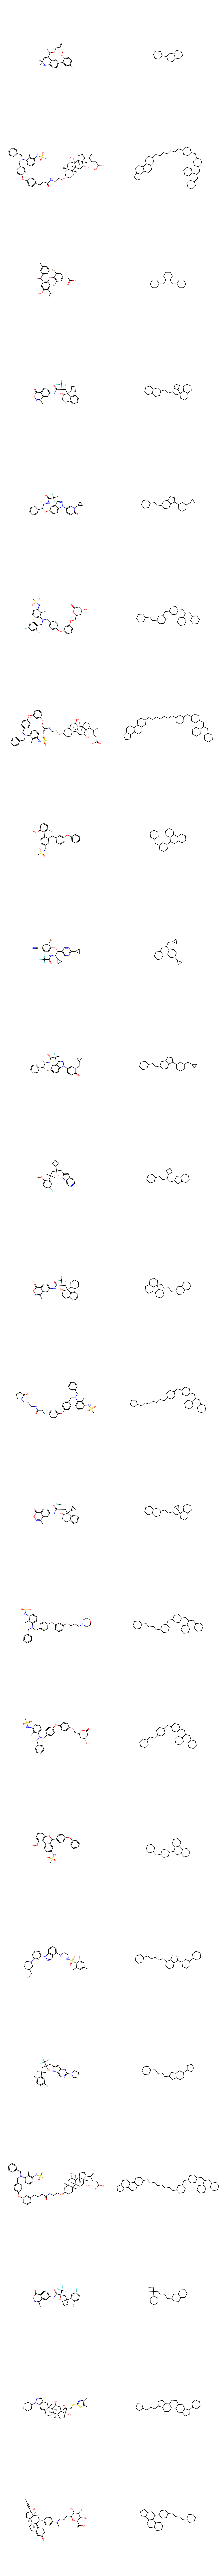

In [54]:
mols = []
for x in range(len(df_not_in_new_active)):
    #df_not_in_active 23 scaffolds
    canonical_smiles = df_not_in_new_active.loc[x]['canonical_smiles']
    pchembl_value = df_not_in_new_active.loc[x]['pchembl_value']
    scaffold =df_not_in_new_active.loc[x]['scaffolds_csk']
    mols.append(Chem.MolFromSmiles(canonical_smiles))
    mols.append(Chem.MolFromSmiles(scaffold))
    d=Draw.MolsToGridImage(mols,molsPerRow=2, subImgSize=(500, 500), returnPNG=False)

display(d)

# Only for intresting how many scaffolds from each cluster I need to delete

In [3]:
#clusters = pd.read_csv("data/input_recall_sets/Glucocorticoid_receptor/Glucocorticoid_receptor_split_to_clusters_using_KMedoids.csv")
clusters = pd.read_csv("data/input_recall_sets/Leukocyte_elastase/Leukocyte_elastase_split_to_clusters_using_KMedoids.csv")

In [4]:
cluster_0 = 0
cluster_1 = 0
cluster_2 = 0
cluster_3 = 0
cluster_4 = 0

for x in df_not_in_new_active.scaffolds_csk:
    #print(x)
    cluster = clusters[clusters.scaffolds_csk == x]['clusters'].item()
    if cluster == 0:
        cluster_0 += 1
    elif cluster == 1:
        cluster_1 += 1
    elif cluster == 2:
        cluster_2 += 1
    elif cluster == 3:
        cluster_3 += 1
    elif cluster == 4:
        cluster_4 += 1

print("CLuster 0: ", cluster_0)
print("CLuster 1: ", cluster_1)
print("CLuster 2: ", cluster_2)
print("CLuster 3: ", cluster_3)
print("CLuster 4: ", cluster_4)



NameError: name 'df_not_in_new_active' is not defined

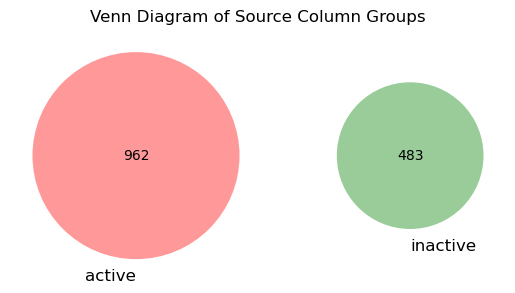

In [57]:
from matplotlib_venn import venn2

output = [i for i in set(list(nuclear_active.canonical_smiles)) if i in set(list(nuclear_nonactive.canonical_smiles))]
len(output)

venn2(subsets=(len(set(list(nuclear_active.canonical_smiles))), len(set(list(nuclear_nonactive.canonical_smiles))), len(output)), set_labels=('active', 'inactive'))
plt.title("Venn Diagram of Source Column Groups")
plt.show()

In [90]:
dont_wanted_scaffold = pd.read_csv("data/input_recall_sets/Glucocorticoid_receptor/new_sets/df_not_in_new_active_sets_new.csv")
dont_wanted_scaffold

,canonical_smiles,scaffolds_csk,pchembl_value
0,C=CCOC(C)C1=CC(C)(C)Nc2ccc(-c3cc(F)ccc3OC)cc21,C1CCC(C2CCC3CCCCC3C2)CC1,7.400000
1,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccc(Oc2cc...,C(CCCC1CCC(CC2CCC(CC(CC3CCCCC3)C3CCCCC3)CC2)CC...,7.770000
2,COc1cc(C(=O)c2cccc(C)c2)c(Oc2c(Br)cc(CC(=O)O)c...,C1CCC(CC2CCCCC2CC2CCCCC2)CC1,7.710000
3,Cc1noc(=O)c2ccc(NC(=O)C(O)(CC3(C4CCC4)CCCc4ccc...,C(CCC1(C2CCC2)CCCC2CCCCC21)CC1CCC2CCCCC2C1,8.165000
4,C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...,C1CCC(CCC2CCC3C(CCC3C3CCCC(C4CC4)C3)C2)CC1,8.410000
5,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccc(Oc2cccc(OC[C@@H...,C1CCC(CCC2CCCC(CC3CCC(CC(CC4CCCCC4)C4CCCCC4)CC...,7.600000
6,Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccccc1)Cc1ccc(Oc2cc...,C(CCCC1CCCC(CC2CCC(CC(CC3CCCCC3)C3CCCCC3)CC2)C...,7.240000
7,COc1cccc2c1-c1ccc(NS(C)(=O)=O)cc1C(c1cccc(Oc3c...,C1CCC(CC2CCCC(C3CC4CCCCC4C4CCCCC34)C2)CC1,7.320000
8,N#Cc1ccc(O[C@H](c2cnc(C3CC3)nc2)[C@@H](NC(=O)C...,C1CCC(CC(CC2CC2)C2CCC(C3CC3)CC2)CC1,7.765000
9,C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...,C1CCC(CCC2CCC3C(CCC3C3CCCC(CC4CC4)C3)C2)CC1,8.360000


In [114]:
df_output_sim_3 = pd.read_csv("data/output_sets/Glucocorticoid_receptor/cOS_Molpher_sim_3_all_columns.csv", header = None)
df_output_sim_3.columns = ['chembl_start', 'chembl_stop', 'start_smiles', 'stop_smiles', 'morph', 'tanimoto', 'length', 'time']
df_output_sim_3['start_scaffold'] = [MurckoScaffoldSmiles(\
                                         Chem.MolToSmiles(MakeScaffoldGeneric\
                                       (Chem.MolFromSmiles(x)))) for x in df_output_sim_3.start_smiles]
df_output_sim_3['stop_scaffold'] = [MurckoScaffoldSmiles(\
                                         Chem.MolToSmiles(MakeScaffoldGeneric\
                                       (Chem.MolFromSmiles(x)))) for x in df_output_sim_3.stop_smiles]
df_output_sim_3

,chembl_start,chembl_stop,start_smiles,stop_smiles,morph,tanimoto,length,time,start_scaffold,stop_scaffold
0,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC12C=CC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
1,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC1CC2C(C(O)CC3(C)C2CCC3(O)C(=O)CSC2=NC3=CC=CC...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
2,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC1CC2C(C(O)CC3(C)C(OC(=O)CSC4=NC5=CC=CC=C5S4)...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
3,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC1=C2N=C(SCC(=O)OC3CCC4C5CC(C)C6=CC(=O)C=CC6(...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
4,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC1=C2N=C(SCC(=O)OC3CC4C5CC(C)C6=CC(=O)C=CC6(C...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
...,...,...,...,...,...,...,...,...,...,...
981766,CHEMBL235208,CHEMBL208840,COc1ccc(F)cc1C(C)(C)CC(O)(CNC(=O)c1cnn(-c2ccc(...,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...,CCC1(CC(O)(C(=O)NC2=CC=C3CC(C)ON=C(C)C3=C2)C(F...,0.484868,26,112.17937,C(CCCC1CCC(C2CCCCC2)C1)CCC1CCCCC1,C(CCC1CCCCC2CCCCC12)CC1CCC2CCCCC2C1
981767,CHEMBL235208,CHEMBL208840,COc1ccc(F)cc1C(C)(C)CC(O)(CNC(=O)c1cnn(-c2ccc(...,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...,CCC1(CC(O)(C(=O)NC2=CC=C3C(=C2)C(C)=NOC3C)C(F)...,0.484868,26,112.17937,C(CCCC1CCC(C2CCCCC2)C1)CCC1CCCCC1,C(CCC1CCCCC2CCCCC12)CC1CCC2CCCCC2C1
981768,CHEMBL235208,CHEMBL208840,COc1ccc(F)cc1C(C)(C)CC(O)(CNC(=O)c1cnn(-c2ccc(...,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...,CCC1(CC(O)(C(=O)NC2=CC=C3C(=C2)C(C)=NOC3O)C(F)...,0.484868,26,112.17937,C(CCCC1CCC(C2CCCCC2)C1)CCC1CCCCC1,C(CCC1CCCCC2CCCCC12)CC1CCC2CCCCC2C1
981769,CHEMBL235208,CHEMBL208840,COc1ccc(F)cc1C(C)(C)CC(O)(CNC(=O)c1cnn(-c2ccc(...,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...,CCC1(CC(O)(C(=O)NC2=CC=C3C(=O)ON=C(C)C3=C2)C(F...,0.484868,26,112.17937,C(CCCC1CCC(C2CCCCC2)C1)CCC1CCCCC1,C(CCC1CCCCC2CCCCC12)CC1CCC2CCCCC2C1


In [115]:
drop_index = []
for scaffold in dont_wanted_scaffold.scaffolds_csk:
    arr_drop_id = df_output_sim_3[df_output_sim_3.start_scaffold == scaffold].index
    for x in arr_drop_id:
        if x not in drop_index:
            drop_index.append(x)
    arr_drop_id = df_output_sim_3[df_output_sim_3.stop_scaffold == scaffold].index
    for x in arr_drop_id:
        if x not in drop_index:
            drop_index.append(x)
print(len(drop_index))
df_output_sim_3_new = df_output_sim_3.copy()
df_output_sim_3_new = df_output_sim_3_new.drop(drop_index)
df_output_sim_3_new.reset_index(level=0, inplace=True, drop = True)
df_output_sim_3_new

180132


,chembl_start,chembl_stop,start_smiles,stop_smiles,morph,tanimoto,length,time,start_scaffold,stop_scaffold
0,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC12C=CC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
1,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC1CC2C(C(O)CC3(C)C2CCC3(O)C(=O)CSC2=NC3=CC=CC...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
2,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC1CC2C(C(O)CC3(C)C(OC(=O)CSC4=NC5=CC=CC=C5S4)...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
3,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC1=C2N=C(SCC(=O)OC3CCC4C5CC(C)C6=CC(=O)C=CC6(...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
4,CHEMBL1917244,CHEMBL1684353,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,C[C@H]1c2c(cc(F)c(-c3cccc4c(Cl)c[nH]c34)c2F)NC...,CC1=C2N=C(SCC(=O)OC3CC4C5CC(C)C6=CC(=O)C=CC6(C...,0.422429,402,11120.55791,C1CCC2CC(CCCC3CCC4C3CCC3C5CCCCC5CCC43)CC2C1,C1CCC(CCCC2CCC3CCC(C4CCCC5CCCC54)CC3C2)CC1
...,...,...,...,...,...,...,...,...,...,...
801634,CHEMBL235208,CHEMBL208840,COc1ccc(F)cc1C(C)(C)CC(O)(CNC(=O)c1cnn(-c2ccc(...,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...,CCC1(CC(O)(C(=O)NC2=CC=C3CC(C)ON=C(C)C3=C2)C(F...,0.484868,26,112.17937,C(CCCC1CCC(C2CCCCC2)C1)CCC1CCCCC1,C(CCC1CCCCC2CCCCC12)CC1CCC2CCCCC2C1
801635,CHEMBL235208,CHEMBL208840,COc1ccc(F)cc1C(C)(C)CC(O)(CNC(=O)c1cnn(-c2ccc(...,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...,CCC1(CC(O)(C(=O)NC2=CC=C3C(=C2)C(C)=NOC3C)C(F)...,0.484868,26,112.17937,C(CCCC1CCC(C2CCCCC2)C1)CCC1CCCCC1,C(CCC1CCCCC2CCCCC12)CC1CCC2CCCCC2C1
801636,CHEMBL235208,CHEMBL208840,COc1ccc(F)cc1C(C)(C)CC(O)(CNC(=O)c1cnn(-c2ccc(...,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...,CCC1(CC(O)(C(=O)NC2=CC=C3C(=C2)C(C)=NOC3O)C(F)...,0.484868,26,112.17937,C(CCCC1CCC(C2CCCCC2)C1)CCC1CCCCC1,C(CCC1CCCCC2CCCCC12)CC1CCC2CCCCC2C1
801637,CHEMBL235208,CHEMBL208840,COc1ccc(F)cc1C(C)(C)CC(O)(CNC(=O)c1cnn(-c2ccc(...,CCC1(CC(O)(C(=O)Nc2ccc3c(=O)onc(C)c3c2)C(F)(F)...,CCC1(CC(O)(C(=O)NC2=CC=C3C(=O)ON=C(C)C3=C2)C(F...,0.484868,26,112.17937,C(CCCC1CCC(C2CCCCC2)C1)CCC1CCCCC1,C(CCC1CCCCC2CCCCC12)CC1CCC2CCCCC2C1


In [116]:
df_output_sim_3_new.to_csv("data/output_sets/Glucocorticoid_receptor/new_sets/cOS_Molpher_sim_3_all_columns.csv", index = False,index_label = False, header = False)

In [14]:



df = pd.read_csv("data/input_recall_sets/Leukocyte_elastase/Leukocyte_elastase_all_data.csv", header = None)
df.columns = ['0', '1', 'pchembl_value', '3', '4', '5' ,'6', '7', '8']
df

,0,1,pchembl_value,3,4,5,6,7,8
0,209495,IC50,4.55,28000.0,Cc1ccc(S(=O)(=O)N2CCN(Cc3ccccc3)C(=O)[C@@H]2CC...,IIUDNCXAVOCQBC-NRFANRHFSA-N,CHEMBL126546,235,Leukocyte elastase
1,239388,IC50,5.31,4900.0,CCOC(=O)C(F)(F)C(=O)[C@H](CC(C)C)NC(=O)CN(C(=O...,MMUFBSFVJPKCDL-TWJUONSBSA-N,CHEMBL142689,235,Leukocyte elastase
2,240053,IC50,6.39,404.0,CCOC(=O)C(F)(F)C(=O)[C@@H](NC(=O)CN(C(=O)[C@@H...,RBVHNXWKPIRSTF-LQJZCPKCSA-N,CHEMBL263927,235,Leukocyte elastase
3,196317,IC50,4.92,12000.0,CCCC[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(...,CEEARFKAZMLMSC-NOCPHRDISA-N,CHEMBL331243,235,Leukocyte elastase
4,239638,IC50,6.20,635.0,CCOC(=O)C(F)(F)C(=O)[C@@H](NC(=O)CN(C(=O)[C@@H...,YHHXDFWUDUOLCT-NSOVKSMOSA-N,CHEMBL344768,235,Leukocyte elastase
...,...,...,...,...,...,...,...,...,...
1497,2565774,IC50,5.11,7690.0,CCC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)C(...,QNTJQVZVZCGYKL-QWXSGBELSA-N,CHEMBL4872003,235,Leukocyte elastase
1498,2549040,IC50,5.93,1170.0,CC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)NC(...,SYGZMCOHVVTSNJ-VEPNZUSMSA-N,CHEMBL4855269,235,Leukocyte elastase
1499,2568387,IC50,5.25,5660.0,CCC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)NC...,JAUVLNCXUQVECW-QWXSGBELSA-N,CHEMBL4874616,235,Leukocyte elastase
1500,2573084,IC50,5.87,1350.0,CC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)OCc...,QUWUYFQPDXTWCR-CVTMBVITSA-N,CHEMBL4879313,235,Leukocyte elastase


1497


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


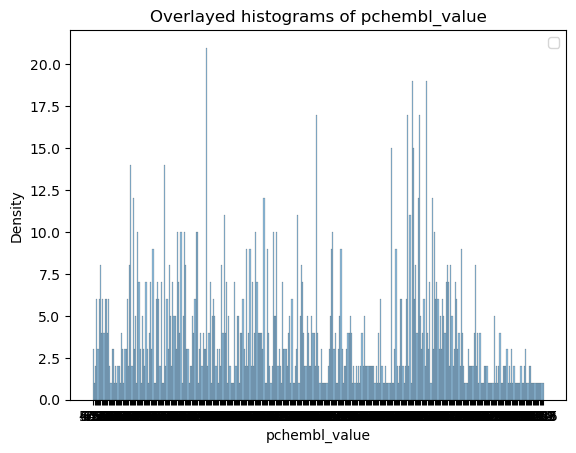

In [18]:
import seaborn as sns
dff = df.drop_duplicates()
print(len(dff))

sns.histplot(dff['pchembl_value'].dropna(), bins=1000, alpha=0.5)
plt.title('Overlayed histograms of pchembl_value')
plt.xlabel('pchembl_value')
plt.ylabel('Density')
plt.legend()
plt.show()